This is a p-value anomality detector for CAN bus signals. Valuses mu and sigma have already been found. 

In [2]:
import os
import numpy as np
import pandas as pd
import importlib
import sys
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')
#add CAN_bus_data_analysis folder to path so that files from this folder can be imported
sys.path.insert(0, 'CAN_bus_data_analysis')

import matplotlib.pyplot as plt

#Neural  network packages
import tensorflow as tf
from tensorflow import keras
from __future__ import print_function
from keras.layers import Dense, Flatten, Dropout, LSTM, TimeDistributed, Bidirectional
from keras.models import Sequential
from keras import optimizers


from keras.callbacks import EarlyStopping
from keras.models import load_model

In [3]:
#Load already trained model
model = load_model('../DNN_models/model_494.HDF5')

The values of mu and sigma, for our p-value based anomaly detector, have already been found.

In [6]:
mu = 1.0141052741679173
sigma = 0.9610836396157294

Read in data with anomaly.

In [14]:
data_anomaly= pd.read_csv('../processed_data_csv/pid_494_with_anomaly')
data_anomaly = data_anomaly.drop(['Unnamed: 0'], axis=1)

Visual of how the data looks like (time snippet with no anomalities)

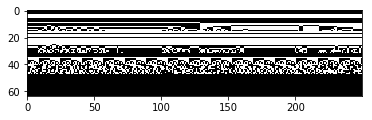

In [22]:
plt.imshow(data_anomaly[5150:5400].T, cmap ='gray')

Visual of how the data looks like (time snippet with anomalities)

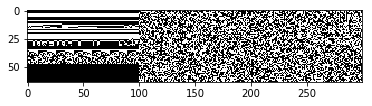

In [23]:
plt.imshow(data_anomaly[19901:20201].T, cmap ='gray')

In [15]:
#Get the data in the format that is required by the neural network. Function below does that
def get_data_matrix_for_rnn_training(data_frame, timestep = 10, shift =1 ):
    """
    input is n x m pandas dataframe (m=number of features (64* #of_pid),
    n = number of samples)
    """

    M = np.array(data_frame)
    x_y_tups = [(M[i:i+ timestep], M[i+timestep]) for i in np.arange(0,M.shape[0]-timestep, shift)]
    X_list, Y_list = list(zip(*x_y_tups))
    X=np.dstack(X_list).swapaxes(0,2).swapaxes(1,2)
    Y=np.array(Y_list)
    return X, Y

X_anomaly, Y_anomaly = get_data_matrix_for_rnn_training(data_anomaly, timestep = 16)


Use already trained model to make prediction

In [16]:
pred_anomaly = model.predict(X_anomaly)

In [ ]:
Construction of a p-value based anomaly detector

In [17]:
diff_anomaly = pred_anomaly - Y_anomaly
error_anomaly_1 = np.linalg.norm(diff_anomaly, axis =1)

anomaly_df = pd.DataFrame(error_anomaly_1, columns = ['error'])
anomaly_df = anomaly_df.iloc[16:]
anomaly_df = anomaly_df.assign(rolling_error_5 = anomaly_df.error.rolling(5).mean())
anomaly_df = anomaly_df.assign(z_score = anomaly_df.rolling_error_5.apply(lambda z: (z - mu)/sigma ))
anomaly_df = anomaly_df.assign(p_val = anomaly_df.z_score.apply(lambda z: st.norm.cdf(z)))

p_value = anomaly_df['p_val'].tolist()
p_value = p_value[5:]

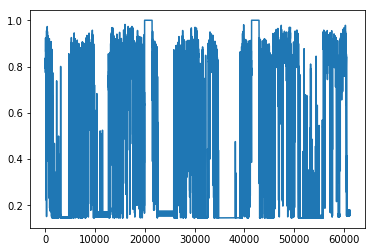

In [18]:
fig = plt.plot(p_value)

Pin point values that lay in the tails of the Gaussian distribution

In [20]:
anomalous_signals = []
for i in range(len(p_value)):
     if p_value[i] < .005:
        anomalous_signals.append(p_value[i])
     elif p_value[i] > .995:
         anomalous_signals.append(p_value[i])
     else:
         anomalous_signals.append(.5)
         pass

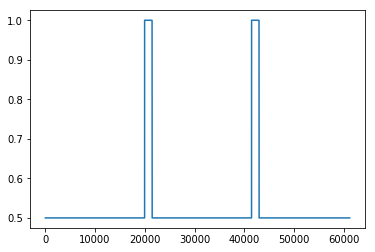

In [21]:
fig_2 = plt.plot(anomalous_signals)

In [ ]:
These are exactly the places where I inserted the anomaly into the data